# **Brain tumor segmentation**

In [ ]:
# all of the imports needed
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from glob import glob
import nibabel as nib
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms
import torchvision.transforms.functional as TF

**Download data from Kaggle**

In [ ]:
# =============================================================================
# SIMPLE KAGGLE SETUP - BRAIN TUMOR DATASET
# =============================================================================

# Step 1: Install Kaggle
print("Installing Kaggle API...")
!pip install -q kaggle

# Step 2: Upload kaggle.json manually
print("\n🔑 UPLOAD YOUR KAGGLE.JSON FILE")
print("=" * 40)
print("If you haven't downloaded it yet:")
print("1. Go to kaggle.com → Your Account → API")
print("2. Click 'Create New API Token'")
print("3. Upload the downloaded file below")
print("=" * 40)

from google.colab import files
uploaded = files.upload()

# Step 3: Setup credentials
import os
os.makedirs('/root/.kaggle', exist_ok=True)
os.rename('kaggle.json', '/root/.kaggle/kaggle.json')
os.chmod('/root/.kaggle/kaggle.json', 0o600)

print("✅ Kaggle API configured!")

# Step 4: Download dataset
print("\n📥 Downloading BraTS brain tumor dataset...")
!kaggle datasets download -d awsaf49/brats20-dataset-training-validation

# Step 5: Extract dataset
print("📂 Extracting dataset...")
import zipfile
os.makedirs('/content/data', exist_ok=True)

with zipfile.ZipFile('brats20-dataset-training-validation.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data/')

# Clean up
os.remove('brats20-dataset-training-validation.zip')

print("✅ Dataset ready at /content/data/")

# Step 6: Check what we got
print("\n📊 Dataset contents:")
for root, dirs, files in os.walk('/content/data/'):
    level = root.replace('/content/data/', '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    for file in files[:3]:  # Show first 3 files
        print(f"{subindent}{file}")
    if len(files) > 3:
        print(f"{subindent}... and {len(files)-3} more files")

print(f"\n🎉 Setup complete! Your data is at: /content/data/")

Installing Kaggle API...

🔑 UPLOAD YOUR KAGGLE.JSON FILE
If you haven't downloaded it yet:
1. Go to kaggle.com → Your Account → API
2. Click 'Create New API Token'
3. Upload the downloaded file below


Saving kaggle.json to kaggle.json
✅ Kaggle API configured!

📥 Downloading BraTS brain tumor dataset...
Dataset URL: https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation
License(s): CC0-1.0
100% 4.14G/4.16G [00:59<00:00, 37.5MB/s]
100% 4.16G/4.16G [01:00<00:00, 74.4MB/s]
📂 Extracting dataset...
✅ Dataset ready at /content/data/

📊 Dataset contents:
/
BraTS2020_TrainingData/
  MICCAI_BraTS2020_TrainingData/
    name_mapping.csv
    survival_info.csv
    BraTS20_Training_233/
      BraTS20_Training_233_t2.nii
      BraTS20_Training_233_flair.nii
      BraTS20_Training_233_seg.nii
      ... and 2 more files
    BraTS20_Training_257/
      BraTS20_Training_257_t1ce.nii
      BraTS20_Training_257_flair.nii
      BraTS20_Training_257_seg.nii
      ... and 2 more files
    BraTS20_Training_128/
      BraTS20_Training_128_seg.nii
      BraTS20_Training_128_t1.nii
      BraTS20_Training_128_t2.nii
      ... and 2 more files
    BraTS20_Training_130/
      BraTS20_Training_

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# This class defines all the hyperparameters and configuration settings
class Config:

    DATA_PATH = '/content/data/'
    IMG_SIZE = 128
    BATCH_SIZE = 6
    EPOCHS = 50
    LEARNING_RATE = 0.0005
    DEVICE = device
    OUTPUT_DIR = '/content/model_outputs/' # Local directory for generated model artifacts
    MODEL_SAVE_PATH = os.path.join(OUTPUT_DIR, 'res_unet_model_Adam.pth')
    SAVE_FIGURE_PATH = os.path.join(OUTPUT_DIR, 'figures_res_unet_model_Adam.png')
    TRAINING_CURVES_PATH = os.path.join(OUTPUT_DIR, 'res_unet_training_curves_Adam.png')

    MODALITIES = ['t1', 't1ce', 't2', 'flair']  # MRI modalities
    AUGMENTATION_PROB = 0.5  # Probability of applying augmentation
    ROTATION_RANGE = 15      # Rotation range in degrees
    BRIGHTNESS_RANGE = 0.2   # Brightness adjustment range
    CONTRAST_RANGE = 0.2     # Contrast adjustment range

os.makedirs(Config.OUTPUT_DIR, exist_ok=True)

class DataAugmentation:
    """Data augmentation class for multi-modal MRI data"""

    def __init__(self, config):
        self.rotation_range = config.ROTATION_RANGE
        self.brightness_range = config.BRIGHTNESS_RANGE
        self.contrast_range = config.CONTRAST_RANGE

    def rotate_image_and_mask(self, image, mask, angle):
        """Rotate image and mask by the same angle"""
        h, w = image.shape[-2:]
        center = (w // 2, h // 2)

        # Get rotation matrix
        rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

        # Rotate each modality
        rotated_modalities = []
        for i in range(image.shape[0]):  # For each modality
            rotated_modality = cv2.warpAffine(
                image[i].numpy(), rotation_matrix, (w, h),
                flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT
            )
            rotated_modalities.append(rotated_modality)

        # Rotate mask
        rotated_mask = cv2.warpAffine(
            mask.numpy(), rotation_matrix, (w, h),
            flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_REFLECT
        )

        return torch.FloatTensor(np.stack(rotated_modalities)), torch.FloatTensor(rotated_mask)

    def flip_image_and_mask(self, image, mask, flip_type):
        """Flip image and mask"""
        if flip_type == 'horizontal':
            flipped_image = torch.flip(image, [-1])
            flipped_mask = torch.flip(mask, [-1])
        elif flip_type == 'vertical':
            flipped_image = torch.flip(image, [-2])
            flipped_mask = torch.flip(mask, [-2])
        else:
            return image, mask

        return flipped_image, flipped_mask

    def adjust_brightness_contrast(self, image, brightness_factor, contrast_factor):
        """Adjust brightness and contrast for all modalities"""
        adjusted_image = image.clone()

        for i in range(image.shape[0]):  # For each modality
            # Apply contrast first, then brightness
            adjusted_image[i] = adjusted_image[i] * contrast_factor + brightness_factor
            # Clamp values to valid range
            adjusted_image[i] = torch.clamp(adjusted_image[i], 0, 1)

        return adjusted_image

    def __call__(self, image, mask):
        """Apply random augmentations"""
        aug_image, aug_mask = image.clone(), mask.clone()

        # Random rotation
        if random.random() < 0.3:
            angle = random.uniform(-self.rotation_range, self.rotation_range)
            aug_image, aug_mask = self.rotate_image_and_mask(aug_image, aug_mask, angle)

        # Random horizontal flip
        if random.random() < 0.3:
            aug_image, aug_mask = self.flip_image_and_mask(aug_image, aug_mask, 'horizontal')

        # Random vertical flip
        if random.random() < 0.2:
            aug_image, aug_mask = self.flip_image_and_mask(aug_image, aug_mask, 'vertical')

        # Random brightness and contrast adjustment
        if random.random() < 0.4:
            brightness_factor = random.uniform(-self.brightness_range, self.brightness_range)
            contrast_factor = random.uniform(1 - self.contrast_range, 1 + self.contrast_range)
            aug_image = self.adjust_brightness_contrast(aug_image, brightness_factor, contrast_factor)

        return aug_image, aug_mask

# Data preprocessing functions
def load_nii_file(filepath):
    """Load NIfTI file and return numpy array"""
    nii_img = nib.load(filepath)
    return nii_img.get_fdata()

def normalize_image(image):
    """Normalize image to 0-1 range"""
    image = image.astype(np.float32)

    min_val = image.min()
    max_val = image.max()
    range_val = max_val - min_val

    if range_val == 0:
        return np.zeros_like(image, dtype=np.float32)
    else:
        # Normalization formula
        image = (image - min_val) / range_val
    return image

def preprocess_mask(mask):
    """Convert BraTS mask to binary (0: background, 1: tumor)"""
    # BraTS labels: 0=background, 1=necrotic, 2=edema, 4=enhancing
    # Convert to binary: 0=background, 1=any tumor
    binary_mask = (mask > 0).astype(np.float32)
    return binary_mask

def extract_2d_slices(volumes, mask, slice_range=(50, 100)):
    """Extract 2D slices from 3D volumes where tumor is present"""
    # volumes is a list of 4 modalities
    slices = []
    masks = []

    for i in range(slice_range[0], min(slice_range[1], volumes[0].shape[2])):
        # Extract slice from each modality
        multi_modal_slice = []
        for volume in volumes:
            slice_2d = volume[:, :, i]
            multi_modal_slice.append(slice_2d)

        mask_2d = mask[:, :, i]

        # Only keep slices with some tumor content
        if np.sum(mask_2d) > 0:
            slices.append(multi_modal_slice)
            masks.append(mask_2d)

    return slices, masks


In [ ]:
class MultiModalBraTSDataset(Dataset):
    def __init__(self, data_paths, transform=None, augment=False):
        """
        data_paths: list of dictionaries, each containing paths to all modalities and mask
        e.g., [{'t1': path, 't1ce': path, 't2': path, 'flair': path, 'seg': path}, ...]
        """
        self.data_paths = data_paths
        self.transform = transform
        self.augment = augment

        if self.augment:
            self.augmentation = DataAugmentation(Config)

    def __len__(self):
        return len(self.data_paths)

    def __getitem__(self, idx):
        paths = self.data_paths[idx]

        # Load all modalities
        volumes = []
        for modality in Config.MODALITIES:
            volume = load_nii_file(paths[modality])
            volume = normalize_image(volume)
            volumes.append(volume)

        # Load mask
        mask = load_nii_file(paths['seg'])
        mask = preprocess_mask(mask)

        # Extract 2D slices
        img_slices, mask_slices = extract_2d_slices(volumes, mask)

        # Randomly select one slice
        if len(img_slices) > 0:
            idx_slice = np.random.randint(0, len(img_slices))
            multi_modal_slice = img_slices[idx_slice]
            mask_slice = mask_slices[idx_slice]
        else:
            # If no tumor slices, take middle slice
            mid_slice = volumes[0].shape[2] // 2
            multi_modal_slice = []
            for volume in volumes:
                multi_modal_slice.append(volume[:, :, mid_slice])
            mask_slice = mask[:, :, mid_slice]

        # Resize all modalities
        resized_modalities = []
        for modality_slice in multi_modal_slice:
            resized_slice = cv2.resize(modality_slice, (Config.IMG_SIZE, Config.IMG_SIZE))
            resized_modalities.append(resized_slice)

        mask_slice = cv2.resize(mask_slice, (Config.IMG_SIZE, Config.IMG_SIZE))

        # Stack modalities to create 4-channel input
        multi_modal_tensor = torch.FloatTensor(np.stack(resized_modalities, axis=0))
        mask_tensor = torch.FloatTensor(mask_slice)

        if self.augment and random.random() < Config.AUGMENTATION_PROB:
            multi_modal_tensor, mask_tensor = self.augmentation(multi_modal_tensor, mask_tensor)

        if self.transform:
            multi_modal_tensor = self.transform(multi_modal_tensor)

        return multi_modal_tensor, mask_tensor

In [ ]:
def load_multimodal_brats_data():
    """Load all complete multimodal BraTS data paths"""
    data_paths = []

    # Set paths
    data_path = '/content/data/'
    train_dir = os.path.join(data_path, 'BraTS2020_TrainingData', 'MICCAI_BraTS2020_TrainingData')

    if not os.path.exists(train_dir):
        print(f"Training directory not found: {train_dir}")
        return []

    # Get all patient directories
    patient_dirs = [d for d in os.listdir(train_dir) if d.startswith('BraTS20_Training_')]

    modalities = ['t1', 't1ce', 't2', 'flair', 'seg']

    for patient_dir in patient_dirs:
        patient_path = os.path.join(train_dir, patient_dir)

        # Check if all modalities exist
        patient_data = {}
        complete = True

        for modality in modalities:
            file_path = os.path.join(patient_path, f"{patient_dir}_{modality}.nii")
            if os.path.exists(file_path):
                patient_data[modality] = file_path
            else:
                complete = False
                break

        if complete:
            patient_data['patient_id'] = patient_dir
            data_paths.append(patient_data)

    return data_paths

# Usage
print("\n=== Loading multi-modal data paths ===")
data_paths = load_multimodal_brats_data()
print(f"Found {len(data_paths)} complete training samples")

if len(data_paths) == 0:
    print("\nERROR: No complete training data found!")
    print("Please check the data directory structure.")
else:
    train_val_data, test_data = train_test_split(data_paths, test_size=0.20, random_state=42)
    print(f"Total data: {len(data_paths)}")
    print(f"Training/Validation data (pre-split): {len(train_val_data)}")
    print(f"Test data: {len(test_data)}")

    train_data, val_data = train_test_split(train_val_data, test_size=0.25, random_state=42)
    print(f"Training samples: {len(train_data)}")
    print(f"Validation samples: {len(val_data)}")

    # Create datasets
    train_dataset = MultiModalBraTSDataset(train_data, augment=True)
    val_dataset = MultiModalBraTSDataset(val_data, augment=False)
    test_dataset = MultiModalBraTSDataset(test_data, augment=False)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=Config.BATCH_SIZE, shuffle=False)


=== Loading multi-modal data paths ===
Found 368 complete training samples
Total data: 368
Training/Validation data (pre-split): 294
Test data: 74
Training samples: 220
Validation samples: 74


In [ ]:
# Residual Double Convolution Block
class ResidualDoubleConv(nn.Module):
    """
    A block consisting of two convolutional layers with BatchNorm, ReLU, and Dropout,
    plus a residual (shortcut) connection.
    """
    def __init__(self, in_channels, out_channels, dropout_prob=0.2):
        super(ResidualDoubleConv, self).__init__()
        # First convolutional block: Conv -> BatchNorm -> ReLU -> Dropout
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout_prob)
        )
        # Second convolutional block: Conv -> BatchNorm -> Dropout (ReLU after shortcut)
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.Dropout2d(dropout_prob)
        )
        self.relu = nn.ReLU(inplace=True)

        # Shortcut connection to match dimensions if needed
        self.shortcut = nn.Identity()
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)

    def forward(self, x):
        identity = self.shortcut(x)

        out = self.conv1(x)
        out = self.conv2(out)

        out = out + identity
        return self.relu(out)

# --- Residual U-Net Architecture (Corrected for Binary Output) ---
class ResUNet(nn.Module):
    """
    U-Net architecture with ResidualDoubleConv blocks for improved gradient flow
    and ability to train deeper networks. Designed for multi-modal input like BraTS.
    Configured for binary segmentation output.
    """
    def __init__(self, in_channels=4, out_channels=1, features=[64, 128, 256, 512], dropout_prob=0.2):
        super(ResUNet, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET (Encoder)
        current_in_channels = in_channels
        for feature in features:
            self.downs.append(ResidualDoubleConv(current_in_channels, feature, dropout_prob))
            current_in_channels = feature

        # Up part of UNET (Decoder)
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2))
            self.ups.append(ResidualDoubleConv(feature * 2, feature, dropout_prob))

        # Bottleneck (deepest part of the network)
        self.bottleneck = ResidualDoubleConv(features[-1], features[-1] * 2)

        # Final 1x1 convolution to map to desired number of output channels (classes)
        # For binary segmentation, out_channels should be 1
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

        # Assert that out_channels is 1 for this configuration
        if out_channels != 1:
            raise ValueError("ResUNet configured for binary output (out_channels=1). "
                             "For multi-class, modify the final activation and loss function.")

    def forward(self, x):
        skip_connections = []

        # Encoder path
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        # Bottleneck
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        # Decoder path
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)

            skip_connection = skip_connections[idx // 2]

            if x.shape[2:] != skip_connection.shape[2:]:
                x = F.interpolate(x, size=skip_connection.shape[2:], mode='bilinear', align_corners=False)

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](concat_skip)

        return torch.sigmoid(self.final_conv(x))

In [ ]:
#Loss functions
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)

        return 1 - dice

class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha
        self.dice_loss = DiceLoss()
        self.bce_loss = nn.BCELoss()

    def forward(self, inputs, targets):
        dice = self.dice_loss(inputs, targets)
        bce = self.bce_loss(inputs, targets)
        return self.alpha * dice + (1 - self.alpha) * bce

In [ ]:
def dice_coefficient(pred, target, smooth=1e-6):
    pred = pred.view(-1)
    target = target.view(-1)

    intersection = (pred * target).sum()
    dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

    return dice.item()


In [ ]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    total_dice = 0

    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        output = output.squeeze(1)  # Remove channel dimension to match target shape
        loss = criterion(output, target)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Calculate dice score
        pred_binary = (output > 0.5).float()
        dice = dice_coefficient(pred_binary, target)
        total_dice += dice

        if batch_idx % 10 == 0:
            print(f'Batch {batch_idx}/{len(loader)}, Loss: {loss.item():.4f}, Dice: {dice:.4f}')

    return total_loss / len(loader), total_dice / len(loader)

# Validation function
def validate_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    total_dice = 0

    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            output = output.squeeze(1)  # Remove channel dimension to match target shape
            loss = criterion(output, target)

            total_loss += loss.item()

            pred_binary = (output > 0.5).float()
            dice = dice_coefficient(pred_binary, target)
            total_dice += dice

    return total_loss / len(loader), total_dice / len(loader)

In [ ]:
def visualize_multimodal_predictions(model, dataset, num_samples=3):
    """Visualize multi-modal model predictions"""
    model.eval()

    fig, axes = plt.subplots(6, num_samples, figsize=(15, 18))

    for i in range(num_samples):
        # Get sample
        img, mask = dataset[i]
        img_batch = img.unsqueeze(0).to(device)

        # Predict
        with torch.no_grad():
            pred = model(img_batch)
            pred = pred.squeeze().cpu().numpy()

        # Convert to numpy
        img_np = img.numpy()
        mask_np = mask.numpy()

        # Plot each modality
        modality_names = ['T1', 'T1ce', 'T2', 'FLAIR']
        for j, modality_name in enumerate(modality_names):
            axes[j, i].imshow(img_np[j], cmap='gray')
            axes[j, i].set_title(f'{modality_name}')
            axes[j, i].axis('off')

        # Plot ground truth
        axes[4, i].imshow(mask_np, cmap='gray')
        axes[4, i].set_title('Ground Truth')
        axes[4, i].axis('off')

        # Plot prediction
        axes[5, i].imshow(pred, cmap='gray')
        axes[5, i].set_title('Prediction')
        axes[5, i].axis('off')

    plt.tight_layout()
    plt.savefig(Config.SAVE_FIGURE_PATH, dpi=300, bbox_inches='tight')
    plt.show()

**Main function to initialize, train and evaluate the model**


Model parameters: 32,431,105

=== Starting Training ===

Epoch 1/50
--------------------------------------------------
Batch 0/37, Loss: 0.9447, Dice: 0.0279
Batch 10/37, Loss: 0.6207, Dice: 0.6942
Batch 20/37, Loss: 0.3427, Dice: 0.5500
Batch 30/37, Loss: 0.2191, Dice: 0.6692
Train Loss: 0.4776, Train Dice: 0.4561
Val Loss: 0.4952, Val Dice: 0.1246
Learning Rate: 0.000500
🎉 New best model saved with Dice: 0.1246

Epoch 2/50
--------------------------------------------------
Batch 0/37, Loss: 0.1885, Dice: 0.7117
Batch 10/37, Loss: 0.3222, Dice: 0.5126
Batch 20/37, Loss: 0.2190, Dice: 0.6858
Batch 30/37, Loss: 0.1939, Dice: 0.6830
Train Loss: 0.2670, Train Dice: 0.5846
Val Loss: 0.2157, Val Dice: 0.6639
Learning Rate: 0.000500
🎉 New best model saved with Dice: 0.6639

Epoch 3/50
--------------------------------------------------
Batch 0/37, Loss: 0.1949, Dice: 0.7215
Batch 10/37, Loss: 0.2465, Dice: 0.6151
Batch 20/37, Loss: 0.1480, Dice: 0.7970
Batch 30/37, Loss: 0.1848, Dice: 0.7373

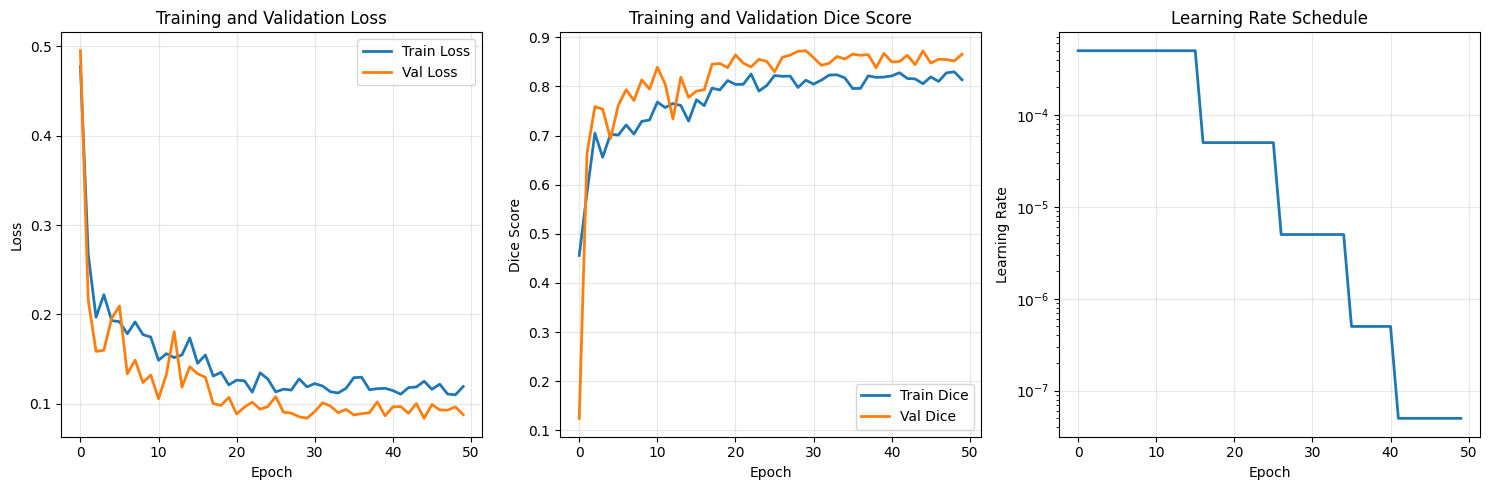


🎉 Training completed! Best validation Dice score: 0.8725

=== Evaluating model on Test Data ===


In [ ]:
def main():
    model = ResUNet(in_channels=4, out_channels=1).to(device)
    criterion = CombinedLoss()
    optimizer = optim.Adam(model.parameters(), lr=Config.LEARNING_RATE,)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

    print(f"\nModel parameters: {sum(p.numel() for p in model.parameters()):,}")

    # Training loop
    train_losses = []
    val_losses = []
    train_dice_scores = []
    val_dice_scores = []
    lr_history = []

    best_val_dice = 0

    print("\n=== Starting Training ===")
    for epoch in range(Config.EPOCHS):
        print(f"\nEpoch {epoch+1}/{Config.EPOCHS}")
        print("-" * 50)

        # Train
        train_loss, train_dice = train_epoch(model, train_loader, criterion, optimizer, device)

        # Validate
        val_loss, val_dice = validate_epoch(model, val_loader, criterion, device)

        # Update learning rate
        scheduler.step(val_loss)


        # Save metrics
        lr_history.append(optimizer.param_groups[0]['lr'])
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_dice_scores.append(train_dice)
        val_dice_scores.append(val_dice)

        print(f"Train Loss: {train_loss:.4f}, Train Dice: {train_dice:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Dice: {val_dice:.4f}")
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

        # Save best model
        if val_dice > best_val_dice:
            best_val_dice = val_dice
            torch.save(model.state_dict(), Config.MODEL_SAVE_PATH)
            print(f"🎉 New best model saved with Dice: {best_val_dice:.4f}")

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train Loss', linewidth=2)
    plt.plot(val_losses, label='Val Loss', linewidth=2)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 3, 2)
    plt.plot(train_dice_scores, label='Train Dice', linewidth=2)
    plt.plot(val_dice_scores, label='Val Dice', linewidth=2)
    plt.title('Training and Validation Dice Score')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Score')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 3, 3)
    plt.plot(lr_history, linewidth=2)
    plt.title('Learning Rate Schedule')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.yscale('log')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(Config.TRAINING_CURVES_PATH, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\n🎉 Training completed! Best validation Dice score: {best_val_dice:.4f}")

if __name__ == "__main__":
    main()


=== Evaluating model on Test Data ===
Final Test Loss: 0.0877, Final Test Dice Score: 0.8641

=== Visualizing multi-modal predictions ===


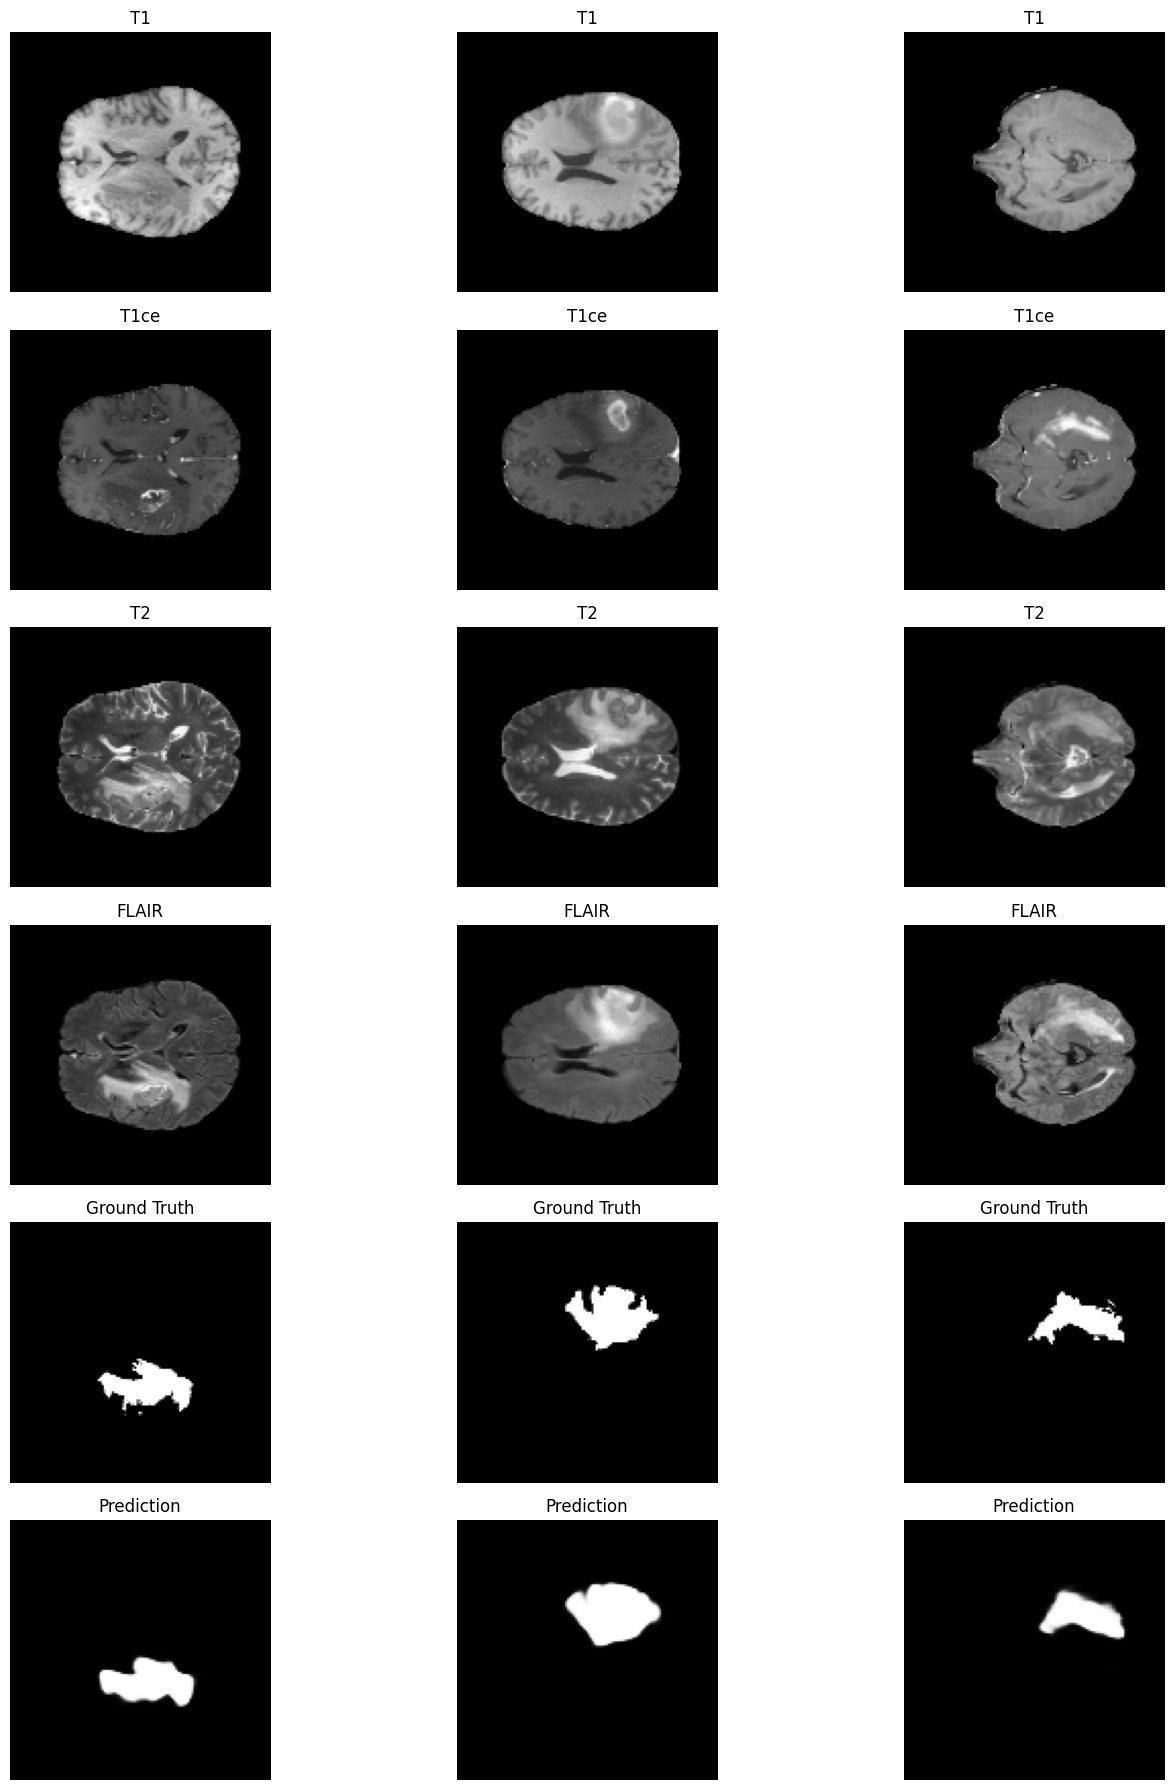

In [ ]:
    model = ResUNet(in_channels=4, out_channels=1).to(device)
    criterion = CombinedLoss()
    print("\n=== Evaluating model on Test Data ===")
    model.load_state_dict(torch.load(Config.MODEL_SAVE_PATH)) # Load best model for final test
    model.eval()

    test_loss, test_dice = validate_epoch(model, test_loader, criterion, device)
    print(f"Final Test Loss: {test_loss:.4f}, Final Test Dice Score: {test_dice:.4f}")

    print("\n=== Visualizing multi-modal predictions ===")
    val_dataset_vis = MultiModalBraTSDataset(test_data[:6])  # Small sample for visualization
    visualize_multimodal_predictions(model, val_dataset_vis)
